In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))


from typing import TypeVar
from methods.MA import ma as method
import pandas as pd

import logging

from plots.color_map_by_method import get_color_map_by_method

from arch.unitroot import ADF
from statsmodels.tsa.forecasting.stl import STLForecast

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

from plots.comparison_plot import comparison_plot


from data.dataset import Dataset, Result
from predictions.Prediction import PredictionData

from sklearn.model_selection import train_test_split


from data.electricity_consumption import energy_demand
from data.dataset import Dataset

Model = TypeVar("Model")

## Key Learning Points
* **Introduction to ARIMA**: Understanding ARIMA's role in time series forecasting and the significance of its parameters (p, d, q).
* **Parameter Determination**: Learning to determine the ARIMA parameters using ACF and PACF plots.

In [2]:
# load the data
dataset_object = energy_demand(zone=["CT"], scale=False)

data = dataset_object.values
display(data.head())

INFO:root:Imputing data for columns ['CT']
INFO:root:columns present: Index(['CT'], dtype='object', name='zone')
INFO:root:Shape of dataframe before imputation: (5175, 1)


Imputing data


zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714


In [3]:

# split the data into training and test sets
training_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

training_data.shape, test_data.shape

((592, 1), (148, 1))

## 1. Training a Basic ARIMA Model

Firstly, we need the model parameters.

The values of p, d, q are specified using the order argument in ARIMA, which takes a tuple (p, d, q).

- **p** represents the number of past observations included in the model, also known as the lag order. Think of **p** as the model's memory: how many steps back in time the model should look to make a prediction. For instance, a **p** of 6 means the model considers the last 6 observations to forecast the next value.
- **d** is the number of times that the original observations are differenced, also known as the degree of differencing. **d** helps make the time series stationary, meaning it removes trends and cycles that could vary over time. A **d** of 0 indicates that we don't need to difference the series because it is already stationary.
- **q** is the size of the moving average window, also called the order of moving average. **q** captures the influence of past errors on the current prediction. For example, a **q** of 2 means the model uses the errors from the two previous forecasts to improve the current prediction.

To determine the value of **p**, we can look at the ACF plot and observe where the plot first crosses the upper confidence interval.
The upper confidence interval is the blue shaded region in the plot below.

To determine the value of **q**, we can look at the PACF plot and observe where the plot first crosses the upper confidence interval.

- In the ACF, the plot crossed the upper confidence interval at lag 6, so we can set **p = 6**.
- In the PACF, there was a significant drop-off at lag 2 or 3, so we can set **q = 2**.

From the earlier ACF and PACF plots, we can deduce that:
- **p = 6** (from ACF)
- **d = 0** (no differencing)
- **q = 2** (from PACF)


In [4]:
(ar_order, integration_order, ma_order) = 6, 0, 2

In [5]:
# Let's train the ARIMA model on the training data

model = sm.tsa.arima.ARIMA(
    training_data["CT"],
    order=(ar_order, integration_order, ma_order),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

trained_model = model.fit()

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 2. Making Predictions With Our New Model

In [6]:
# Now let's make predictions on the test data

predictions = trained_model.predict(
    start=test_data.index[0], end=test_data.index[-1], dynamic=False
)
display(predictions.head())

2014-07-06    3077.032141
2014-07-13    3181.095757
2014-07-20    3251.641662
2014-07-27    3315.320778
2014-08-03    3364.209022
Freq: W-SUN, Name: predicted_mean, dtype: float64

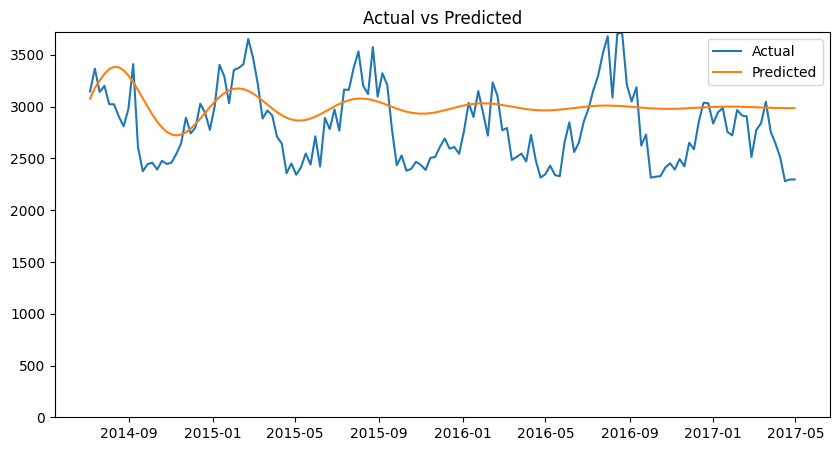

In [7]:
# Now let's plot the predictions against the actual values

plt.figure(figsize=(10, 5))
plt.plot(test_data["CT"], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("Actual vs Predicted")
plt.ylim(0, max(test_data["CT"].values.max() , predictions.values.max() ))
plt.legend()
plt.show()


## 2. Improving Our Model

After reviewing our initial model's predictions, it's clear that there's room for improvement. Don't worry if your first attempt didn't yield great results—this is a common part of the data science process, and there's always a way to enhance our models!

### Finding the Best Parameters

- **Refining Our Approach**: To begin with, we can improve our ARIMA model by meticulously searching for the optimal set of parameters (AR, I, and MA). This process is known as a **grid search**, where we test multiple combinations of parameters to find the one that produces the best results. Imagine trying on different outfits until you find the perfect match for an occasion. In our case, the occasion is forecasting, and the outfit is our model's parameters.

### Addressing Seasonality

- **The Challenge with Seasonality**: Our initial ARIMA model didn't account well for seasonality, which is a recurring pattern over time. Think of seasonality like the way we experience seasons throughout the year, with predictable changes in weather. In time series data, these predictable patterns can significantly impact our forecasts.

- **A Better Approach with STLForecast**: To better manage seasonality, we'll turn to **STLForecast**. STL stands for **Seasonal-Trend Decomposition using Loess**, a technique that breaks down our time series into three key components: **seasonal**, **trend**, and **residual**. It's like dissecting a complex dish into its ingredients to understand what makes it delicious. By applying ARIMA to the residual component—essentially the part of the data not explained by the season or trend—and then recombining it with the seasonal and trend components, we get a more accurate and holistic prediction.

**Note**: STLForecast is especially powerful because it allows us to handle the seasonality in a more nuanced and flexible way, adapting to both strong and subtle seasonal patterns.

By refining our parameters through grid search and adopting STLForecast to address seasonality, we're well on our way to achieving better forecasts. Let's dive in and see how these adjustments can enhance our time series modelling!


In [8]:
def __number_of_steps(data: Dataset) -> int:
    return int(len(data.values) // 5)


def __get_training_set(data: Dataset) -> pd.DataFrame:
    return data.values[: -__number_of_steps(data)][data.subset_column_name]


def __get_test_set(data: Dataset) -> pd.DataFrame:
    return data.values[-__number_of_steps(data) :][data.subset_column_name]


def __evaluate_ma_model(
    data: Dataset, arima_order: tuple, trend: str
) -> Result:
    """Evaluate an ARIMA model for a given order (p,d,q) and return RMSE"""
    # set up the model and fit it
    training_set = __get_training_set(data)
    # make predictions
    model = STLForecast(
        endog=training_set,
        period=52,
        model=sm.tsa.ARIMA,
        model_kwargs={"order": arima_order, "trend": trend},
    )
    model_fit = model.fit()

    # return return in sample bayesian information criterion
    return model_fit.model_result.bic 

## Understanding Grid Search and BIC in Model Selection

When building time series models, finding the right parameters is crucial for accurate forecasting. Here's how we fine-tune our ARIMA model using grid search and evaluate our choices with the Bayesian Information Criterion (BIC).

### The Grid Search Method

- **Exploring Combinations**: Think of grid search as exploring a grid where each cell represents a different combination of parameters for our model. We systematically test each combination to see which one performs the best.

- **Parameters in Play**: We're adjusting three key parameters: **p** (autoregression order), **d** (degree of differencing), and **q** (moving average order), along with **trend** configurations. This allows us to fine-tune how the model accounts for trends, seasonality, and noise in the data.

- **The Process**: Our function `__evaluate_models` goes through every possible combination of these parameters, assessing each one's performance using a specific evaluation metric.

### The Role of BIC

- **What is BIC?**: The Bayesian Information Criterion (BIC) is a type of model scoring or evaluation metric. It helps us choose the best model among a set of models by balancing model complexity against goodness of fit.

- **Why BIC Matters**: A lower BIC score indicates a better model, as it suggests that the model is neither too simple to capture the data's structure nor too complex to be impractical. BIC helps us find the sweet spot.

- **Optimising with BIC**: In our grid search, we compare the BIC scores for each model configuration. The combination of parameters yielding the lowest BIC score is considered the best, as it likely offers the most accurate forecasts with the right balance of simplicity and detail.

By employing grid search and using BIC as our guide, we can systematically find the most effective parameters for our ARIMA model, enhancing its forecasting accuracy and reliability.

Remember, the goal is to find a model that captures the essential patterns in our data without overfitting or underfitting, and these techniques are vital tools in that quest.


In [9]:
def __evaluate_models(
    data: Dataset, p_values: list, d_values: list, q_values: list, trend_values: list   
) -> Result:
    """Evaluate combinations of p, d and q values for an ARIMA model"""
    best_score, best_cfg, best_trend = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for t in trend_values:
                    order = (p, d, q)
                    try:
                        evaluation_metric = __evaluate_ma_model(
                            data, arima_order=order, trend=t
                        )
                        if evaluation_metric < best_score:
                            best_score, best_cfg, best_trend = evaluation_metric, order, t
                        logging.info(f"ARIMA{order} Trend={t} BIC={evaluation_metric}")
                    except Exception as e:
                        logging.error(f"ARIMA{order} Trend={t} failed with error: {e}")
                        continue
    logging.info(f"Best MA: {best_cfg} Best trend: {best_trend} BIC={best_score}")
    return best_cfg, best_trend

__p_values = [5, 6, 8] # autoregression
__d_values = [0, 1, 2] # differencing
__q_values = [0, 1, 2, 4] # moving average 
__trend_values = ["c", "t", "ct"] # trend

def __get_best_model_order(data: Dataset) -> Model:
    """Get the best model order for the ARIMA model"""
    return __evaluate_models(data, __p_values, __d_values, __q_values, __trend_values)


In [10]:
(ar_order, integ_order, ma_order), trend = __get_best_model_order(dataset_object)

INFO:root:ARIMA(5, 0, 0) Trend=c BIC=7588.162636299587
INFO:root:ARIMA(5, 0, 0) Trend=t BIC=7621.89182783224
INFO:root:ARIMA(5, 0, 0) Trend=ct BIC=7570.4238100442635
INFO:root:ARIMA(5, 0, 1) Trend=c BIC=7571.282849189932
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:root:ARIMA(5, 0, 1) Trend=t BIC=7580.294866046614
INFO:root:ARIMA(5, 0, 1) Trend=ct BIC=7570.948312116383
/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/frankkelly/Library/Ca

In [11]:
model = STLForecast(
        endog=__get_training_set(dataset_object),
        model=sm.tsa.ARIMA,
        model_kwargs=dict(order=(ar_order, integ_order, ma_order), trend=trend),
        period=52,
    )
best_fitted_model= model.fit()

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
def __forecast(model: Model, data: Dataset) -> PredictionData:
    """
    Makes a prediction for the next 20% of the data using the fitted model.
    """
    title = f"{data.subset_column_name} forecast for {data.subset_row_name} with simple MA"
    prediction = model.forecast(__number_of_steps(data))
    length_in_sample = len(__get_training_set(data).values)
    # prediction_in_sample = model.get_prediction(0,length_in_sample).summary_frame()
    prediction_summary = model.model_result.get_forecast(__number_of_steps(data)).summary_frame()
    combined_data = pd.concat([prediction, prediction_summary], axis=1)
    combined_data.rename(columns={0: "forecast"}, inplace=True)


    return PredictionData(
        method_name="MA",
        values=combined_data,
        prediction_column_name="forecast",
        ground_truth_values=__get_test_set(data),
        confidence_columns=["mean_ci_lower", "mean_ci_upper"],
        title=title,
        plot_folder=f"{data.name}/{data.subset_row_name}/MA/",
        plot_file_name=f"{data.subset_column_name}_forecast_{data.subset_row_name}_MA",
        # number_of_iterations=__calculate_number_of_configs(__p_values, __d_values, __q_values, __trend_values),
        confidence_on_mean=True,
        confidence_method="95% confidence interval",
        color=get_color_map_by_method("MA"),
        # in_sample_prediction=prediction_in_sample.iloc[:, 0],
    )

In [13]:
predictions_grid_STL = __forecast(best_fitted_model, dataset_object)

In [14]:
predictions_grid_STL.values.head()

,forecast,mean,mean_se,mean_ci_lower,mean_ci_upper
2014-07-06,3681.416236,2855.691260,136.616939,2587.926979,3123.455541
2014-07-13,3687.652000,2883.268336,144.418486,2600.213304,3166.323367
2014-07-20,4183.317694,2883.703404,146.138118,2597.277956,3170.128851
2014-07-27,3374.579562,2898.313290,148.900855,2606.472977,3190.153603
2014-08-03,3318.186202,2901.341956,149.496351,2608.334493,3194.349419


In [15]:
__get_training_set(dataset_object)

zone,CT
ts,
2003-03-02,3254.000000
2003-03-09,3328.714286
2003-03-16,3268.714286
2003-03-23,2805.571429
2003-03-30,2732.285714
...,...
2014-06-01,2499.571429
2014-06-08,2619.285714
2014-06-15,2652.571429


INFO:root:

Plotting ['CT'] forecast for None with simple MA with pre-defined confidence intervals




ground truth max: 3717.8267142857144
prediction max: 4187.062436275956
training data max: 4358.142857142857


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

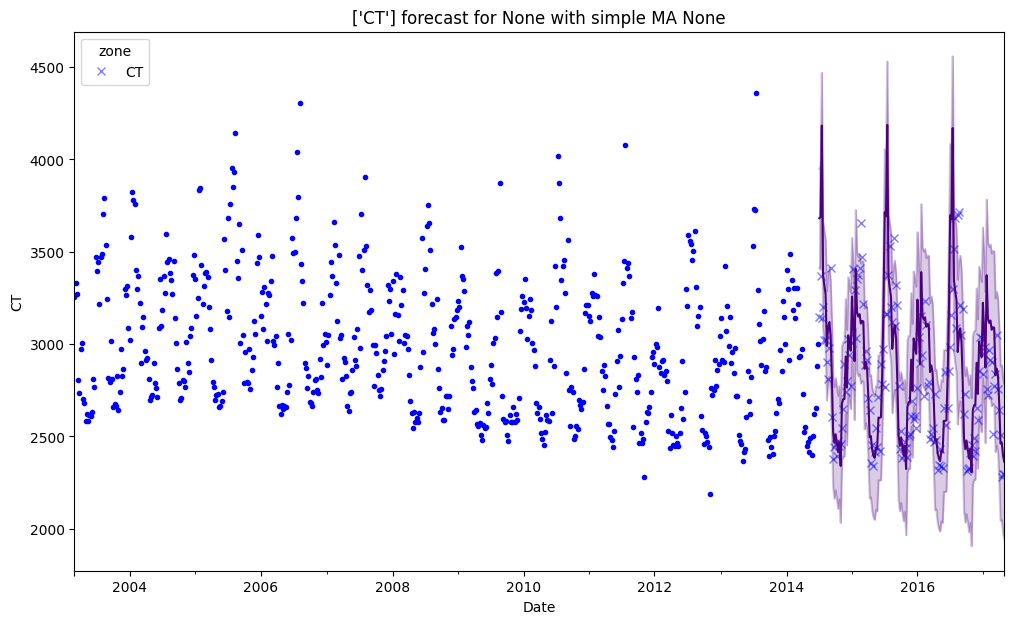

In [18]:

comparison_plot(__get_training_set(dataset_object), predictions_grid_STL)
